# Are there racial disparities in police killings?
## Yuan Meng
October 26, 2019

**(I wrote a Medium story about this project, which you can read [here](https://medium.com/@yuanmeng_37677/are-there-racial-disparities-in-police-killings-b6d738c67cfd)!)**

## Background

On October 12, 2019, Atatiana Jefferson's neighbor called the Dallas police; he heard noises and suspected a break-in. When officer Aaron Dean arrived, he shot and killed Jefferson without finishing his warning. The 28-year-old Black woman had done nothing but playing video games with her nephew that night. 

**Were the victim not Black, would she have been killed?** After every tragedy, this question begs for an answer. 

We can't travel back in time and alter a victim's race to see if it changes the outcome. However, we might detect potential racial biases by **examining whether each race's death rate from police killing is proportional to it base rate in the population**. The logic goes like this: If police encounters are truly random, then the "encounter rate" of each race should be proportional to its base rate (e.g. base rate $\times$ $ \theta$); if the police were race-blind when using lethal force, each race should have the same death rate (e.g., $\alpha$) during these encounters. If both assumptions were true, then dividing any race's death rate by its base rate should give us the same result ($\theta \times \alpha$). We can examine police killing and demographic data to see if this is indeed the case.

## Data
I obtained each state's demographic data from [Population Distribution by Race/Ethnicity](https://www.kff.org/other/state-indicator/distribution-by-raceethnicity/?dataView=1&currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D), which was based on the 2017 Census Bureau’s American Community Survey (ACS). Since the racial makeup of each state has barely changed [over the past 10 years](https://www.kff.org/other/state-indicator/distribution-by-raceethnicity/?dataView=0&activeTab=graph&currentTimeframe=0&startTimeframe=9&selectedDistributions=white&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D), I decide to use this one dataset for all demographic analyses.

Official data on police killings are surprisingly sparse. After years of urging from the U.S. Congress, the FBI finally compiled the [National Use-of-Force Data Collection](https://www.fbi.gov/services/cjis/ucr/use-of-force) but hasn't made it public. On the other hand, volunteers have collected huge amounts of data from crowdsourced reports and public homicide records; the largest three are [Fatal Encounters (FE)](https://fatalencounters.org/), [the U.S. Police Shootings Database](https://docs.google.com/spreadsheets/d/1cEGQ3eAFKpFBVq1k2mZIy5mBPxC6nBTJHzuSWtZQSVw/edit#gid=1144428085), and [Killed by Police](https://killedbypolice.net/). While these databases have many records (e.g., FE has 26,830 records since 2000), they lack information about the circumstances of the killings, such as whether the civilian was armed, showed any signs of mental illness, fled from the police, and so on. Several journalist-maintained datasets (e.g., [Mapping Police Violence](https://mappingpoliceviolence.org/), [The Guardian](https://www.theguardian.com/us-news/ng-interactive/2015/jun/01/the-counted-police-killings-us-database), [VICE News](https://news.vice.com/en_us/article/a3jjpa/nonfatal-police-shootings-data), and [The Washington Post](https://github.com/washingtonpost/data-police-shootings)) filled in on these details using various sources such as news reports, social media, or records requested from police departments. 

For my analysis, I will use the Mapping Police Violence dataset. The Guardian and VICE News haven't updated their data since 2016 and The Washington Post only has shooting data. Not only is Mapping Police Violence reasonably update-to-date (2013-2018) but it also includes all means of police killings. 




## Questions
I will explore the following three questions in this project:
1. **Who were the police more likely to kill?** 
   - Which races have the highest death rates from police killing compare to base rates? 
   - How do the above results differ across genders and ages?
2. **Why were the police more likely to kill them?** *For being more threatening?*
   - Were African American victims more threatening during police encounters?
   - Were there still racial disparities among non-threatening civilians?
3. **Where are racial disparities at the extremes?**
   - In which states does each race have the highest death rates compared to base rates?

## Investigation

In [311]:
# Load the data science toolkit
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Use FiveThirtyEight-style plots
import matplotlib.style as style
style.use('fivethirtyeight')

# Calculate correlation 
from scipy.stats import pearsonr

First, let's see what's in our two datasets and clean the data if necessary.

In [312]:
# Load Mapping Police Violence 
data = pd.read_csv('police_killings.csv')
data.replace('', np.nan, inplace=True) # Replace empty cells with NaN

In [244]:
# Take a look at the first two rows
data.head(2)

,name,age,sex,race,date,city,state,zipcode,county,agency,...,disposition,criminal_charges,mental_illness,armed,weapon,threat_level,fleeing,body_cam,WaPo_id,Unnamed: 20
0,Iosia Faletogo,30,Male,Pacific Islander,12/31/18,Seattle,WA,98103.0,King,Seattle Police Department,...,Pending investigation,No known charges,No,Allegedly Armed,gun,attack,Foot,No,4332.0,NaN
1,Name withheld by police,NaN,Male,Unknown race,12/31/18,Van Nuys,CA,91405.0,Los Angeles,Los Angeles Police Department,...,Pending investigation,No known charges,No,Allegedly Armed,knife,other,Not fleeing,Yes,4340.0,NaN


In [313]:
# The last column that doesn't seem useful; drop it
data = data.drop(data.columns[-1],axis=1) 

In [315]:
# Which races were included?
data['race'].value_counts()

White               3081
Black               1770
Hispanic            1193
Unknown race         473
Asian                108
Native American      100
Unknown Race          77
Pacific Islander      36
Name: race, dtype: int64

In [317]:
# Replace "Unknown Race" with "Unknown race", which refer to the same group
data['race'].replace('Unknown Race', 'Unknown race', inplace=True)

In [316]:
# How many records?
print("This dataset has {} records and {} columns.".format(len(data), len(data.columns)))

This dataset has 6847 records and 20 columns.


In subsequent analyses, I will focus on the following 3 aspects and 8 variables:
1. Demographics of victims: `race`, `sex`, `age`
2. Location of killings: `state`
3. Circumstances of killings:
   - Whether the victim was armed (`armed`): Allegedly armed, unarmed, vehicle, unclear.
   - Whether the victim showed signs of mental illness (`mental_illness`): No, yes, drug or alchool use, unknown.
   - Whether the victim was fleeing from the police (`fleeing`): Not fleeing, car, foot, other.
   - Whether the victim was threatening the police (`threat_level`): Attack, undetermined, other.

In [318]:
# Load Population Distribution by Race/Ethnicity data
demo = pd.read_csv('demo_race.csv')
demo.replace('', np.nan, inplace=True) # Replace empty cells with NaN

# Look at first two rows
demo.head(2)

,state,white_pop,black_pop,hispanic_pop,asian_pop,native_pop,islander_pop,other_pop,state_pop
0,AK,3119100,1259900,195700,63800,19800.0,NaN,81800,4741400
1,AL,433000,18000,47400,46600,95500.0,6300.0,63300,710100


The Population Distribution by Race/Ethnicity dataset shows each race's population (Whites, Blacks, Hispanics, Asians, Native Americans, Pacific Islanders, and other races) in each of the 51 states (including District of Columbia) in the United States.

## Are Blacks are likely to be killed by the police?
### Raw numbers

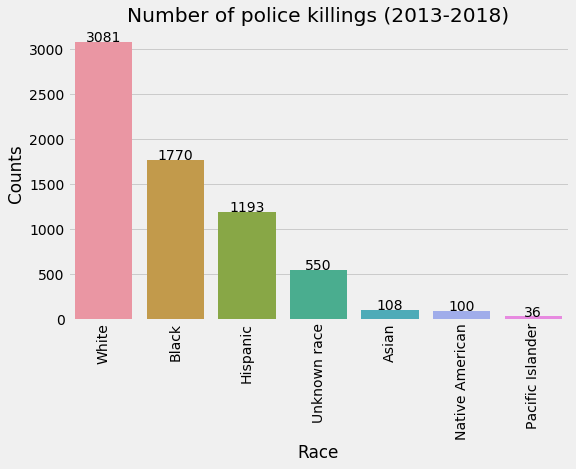

In [172]:
# Set figure size
plt.figure(figsize=(8,5))

# Plot each race's death count in descending order
graph = sns.countplot(x='race', 
                      data=data,
                      order = data['race'].value_counts().index)
graph.set_xticklabels(graph.get_xticklabels(), rotation=90)

# Add count to each bar
i=0
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height,
        data['race'].value_counts()[i],ha="center")
    i += 1
    
# Title + labels
plt.title("Number of police killings (2013-2018)")
plt.xlabel('Race')
plt.ylabel('Counts')

plt.show()

A total of 3081 White Americans were killed by the police between 2013 and 2018, which is more than any other races and nearly twice as many as Blacks (1770 killed). However, the absolute number of deaths means little since each race has a different base rate in the population. If police killings are strictly blind to race, then 5 times as many Whites as Blacks would be killed (Blacks and Whites make up about 12% and 60% of the U.S. population, respectively) — rather than equally as many or twice as many (as shown in the graph).

### Deaths per million by race
To correct for base rate differences, we can divide each race's death rate by it base rate. For simplicity, we can multiply the two rates by the U.S. population and **divide each race's number of deaths from police killing by its national population**. Since this number would be too small to visualize, I multiplied it by a million and see how many per million were killed by the police. (Because "Unknown race" in the police killing data and "other" in the demographic data could refer to different groups, I will exclude these categories.)

In [173]:
# Number of police killings in the order of White, Black, Hispanic, Asian, Native American, Pacific Islander
death_counts = data.loc[data['race'] != 'Unknown race', 'race'].value_counts().to_numpy()

# National population of each race in the same order
race_population = demo.iloc[: , 1:7].sum(axis=0).to_numpy()

# Deaths per million people each race
race_order = ['White', 'Black', 'Hispanic', 'Asian', 'Native American', 'Pacific Islander']
per_million = pd.Series(death_counts/race_population * 1e6, index = race_order)

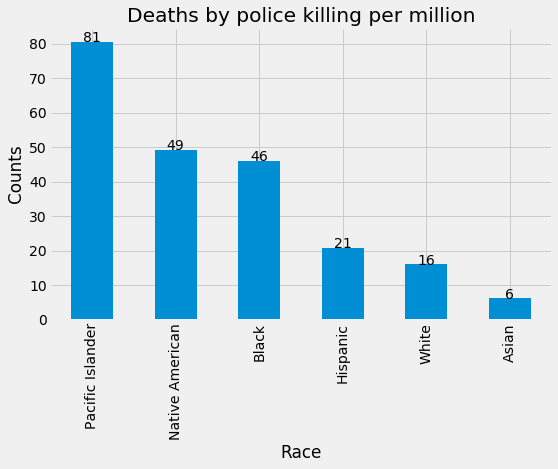

In [174]:
# Set figure size
plt.figure(figsize=(8,5))

# Plot each race's deaths per million in descending order
graph1 = per_million.sort_values(ascending=False).plot(kind='bar')

# Add count to each bar
graph1.set_xticklabels(graph1.get_xticklabels(), rotation=90)
i=0
for p in graph1.patches:
    height = p.get_height()
    graph1.text(p.get_x()+p.get_width()/2., height,
               per_million.sort_values(ascending=False).round(0).astype(int)[i],ha="center")
    i += 1
    
# Title + labels
plt.xlabel('Race')
plt.ylabel('Counts')
plt.title('Deaths by police killing per million')

plt.show()

About 81 per million Pacific Islanders were killed by the police, which is the highest among all races. However, since there are only 36 records of Pacific Islanders, we don't know if this result can confidently reflect their actual risk of being killed by the police. For this concern, I will leave out Pacific Islanders in analyses using the deaths per million measure. Right after Pacific Islanders, Native Americans and Blacks have the highest number of deaths per million (49 and 46, respectively). By comparison, only about 1/3 as many Whites per million were killed by the police. These disparities suggest that overall, Blacks and other racial minorities like Native Americans were indeed more likely than Whites to become victims of police killings. 

### Deaths per million by race and age

How does the risk of getting killed by the police change with age? Does the pattern differ for each race? Below I will look at how deaths per million vary with age across different races.

In [248]:
# Covert age to numeric
data['age'] = data['age'].fillna('') # Replace NaNs with empty strings 
data['age'] = [age.replace('s', '') for age in data['age']] # Same age values have "s"; replace with empty strings
data['age'] = pd.to_numeric(data['age'], errors='coerce')# Convert to numeric; 'coerce' empty strings into NaNs

# Create a data frame where each row is a age and each column a race
age = pd.crosstab(data['age'], data['race'])
age['age'] = age.index

# Drop Pacific Islanders and unknown race
age = age.drop(['Pacific Islander', 'Unknown race'], axis=1)

# Reorder each race's population to match the age dataframe
race_population_2 = demo[['asian_pop', 'black_pop', 'hispanic_pop', 'native_pop', 'white_pop']].sum(axis=0).to_numpy() / 1e6

# Replace counts with deaths per million 
for i in range(5):
    age.iloc[: , i] = age.iloc[: , i].divide(race_population_2[i])
    
# To plot with Seaborn, convert wide format to long format 
age_long = pd.melt(age,id_vars="age",var_name='race', value_name='death_per_million')

# Convert age and deaths per million to floats
age_long['age'] = age_long['age'].astype(float)
age_long['death_per_million'] = age_long['death_per_million'].astype(float)

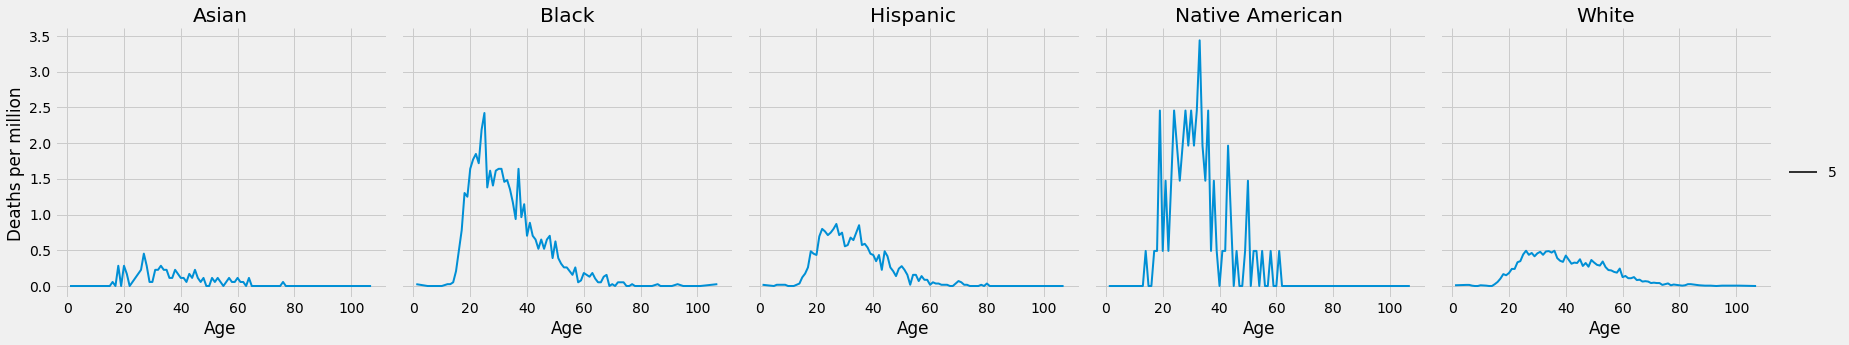

In [249]:
# Plot each race in a separate facetgrid
g = sns.relplot(x="age", y="death_per_million", col="race",
                size=5, aspect=1, facet_kws=dict(sharex=True),
                kind="line", legend="full", data=age_long)

# Change label of each facetgrid
axes = g.axes.flatten()
axes[0].set_title("Asian")
axes[1].set_title("Black")
axes[2].set_title("Hispanic")
axes[3].set_title("Native American")
axes[4].set_title("White")

# Change x-axis label
for ax in axes:
    ax.set_xlabel("Age")
    
# Change y-axis label 
for ax in axes:
    ax.set_ylabel("Deaths per million")

plt.show()

In [250]:
# Peak age of Black killed per million
max_deaths_id = age_long.loc[age_long['race'] == 'Black','death_per_million'].idxmax(axis=0, skipna=True)
max_age = age_long['age'].iloc[max_deaths_id]
max_deaths = age_long['death_per_million'].iloc[max_deaths_id]
print("At age {}, {} per million Blacks are killed by the police.".format(max_age.round(0).astype(int), max_deaths.round(2)))

At age 25, 2.42 per million Blacks are killed by the police.


Across all ages, more per million Native Americans and Blacks were killed than the other races. Disparities between Whites and Blacks exist across the entire age spectrum and are most extreme between ages 18 and 40 . At the peak age 25, 2.42 per million Blacks were killed whereas the number for Whites never reaches 0.5 per million. 

### Deaths per million by gender and race

Let's take a closer look at each race's deaths per million by gender. (Because there are only 6 documented deaths of transgender people, I will focus on males and females in this analysis.)

In [251]:
data['sex'].value_counts()

Male           6428
Female          400
Transgender       6
Unknown           4
Name: sex, dtype: int64

In [252]:
# Create a data frame where each row is a gender and each column a race
gender = pd.crosstab(data['sex'], data['race'])
gender = gender.iloc[0:2]

# Only select Whites, Blacks, Hispanics, and Asians
gender = gender.drop(['Pacific Islander', 'Unknown race'], axis=1)

# Replace counts with deaths per million 
for i in range(5):
    gender.iloc[: , i] = gender.iloc[: , i].divide(race_population_2[i])
    
# To plot with Seaborn, convert wide format to long format 
gender['Gender'] = gender.index
gender_long = pd.melt(gender,id_vars="Gender",var_name='race', value_name='death_per_million')

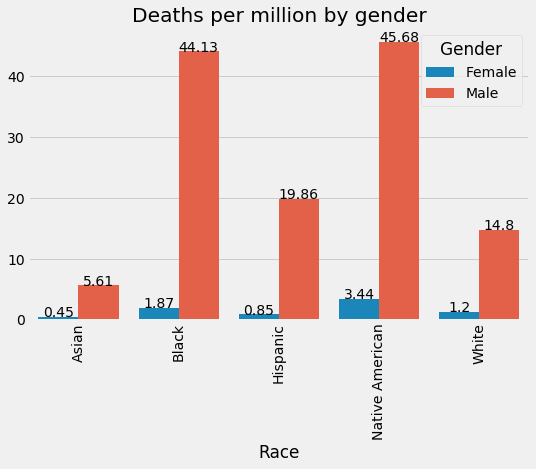

In [253]:
# Set figure size
plt.figure(figsize=(8,5))

# Death per million
graph3 = sns.barplot(x="race", y="death_per_million", hue="Gender", data=gender_long)

# Deaths per millions ranked by gender
deaths_female = gender_long.loc[gender_long['Gender'] == 'Female', 'death_per_million']
deaths_male = gender_long.loc[gender_long['Gender'] == 'Male', 'death_per_million']
deaths = pd.concat([deaths_female, deaths_male]).round(2).tolist()

# Add count to each bar
graph3.set_xticklabels(graph3.get_xticklabels(), rotation=90)
i=0
for p in graph3.patches:
    height = p.get_height()
    graph3.text(p.get_x()+p.get_width()/2., height, deaths[i],ha="center")
    i += 1
    
# Title + labels
plt.title('Deaths per million by gender')
plt.xlabel('Race')
plt.ylabel('')

plt.show()

Across all races, more per million males than females were killed by the police. Disparities between Blacks and Whites exist in both genders, albeit to a lesser degree among females: With every White female killed, there were 1.56 Black females killed; with every White male killed, there were 2.98 Black males killed.

## Why were Blacks more likely to be killed than Whites?
Was it because they were more threatening during police encounters compared to Whites? From the data, we can first look at the proportion of each race exhibiting one of the four threatening behaviors: Carrying arms, showing signs of mental illness, fleeing from or attacking the police.
### Threatening behaviors by race

In [191]:
# Drop unknown races
data = data[(data['race']!= 'Unknown race')]

# Proportion of each race being armed
armed = pd.crosstab(data['race'], data['armed'])
armed['armed_rate'] = armed['Allegedly Armed']/armed.sum(axis=1)

# Proportion of each race showing signs of mental illness
mental_illness = pd.crosstab(data['race'], data['mental_illness'])
mental_illness['mental_illness_rate'] = mental_illness['Yes']/mental_illness.sum(axis=1)

# Proportion of each race fleeing from the police
fleeing = pd.crosstab(data['race'], data['fleeing'])
fleeing['fleeing_rate'] = 1 - fleeing['Not fleeing']/fleeing.sum(axis=1)

# Proportion of each race attacking the police
attack = pd.crosstab(data['race'], data['threat_level'])
attack['attack_rate'] = attack['attack']/attack.sum(axis=1)

# Sort from large to small
armed = armed.sort_values(['armed_rate'])[::-1].reset_index(drop=False)
mental_illness = mental_illness.sort_values(['mental_illness_rate'])[::-1].reset_index(drop=False)
fleeing = fleeing.sort_values(['fleeing_rate'])[::-1].reset_index(drop=False)
attack = attack.sort_values(['attack_rate'])[::-1].reset_index(drop=False)

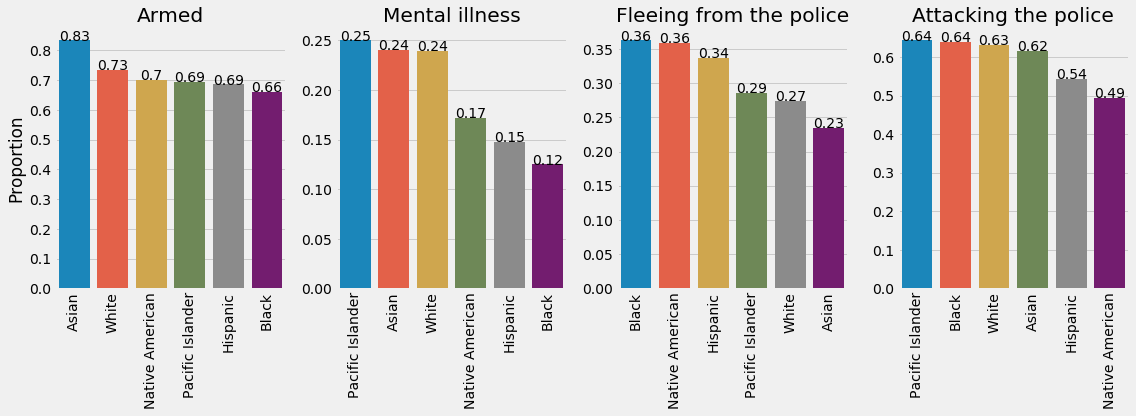

In [192]:
# Plot each of the 4 results
plt.figure(figsize=(16, 6))

# Being Armed
plt.subplot(1, 4, 1)
graph1 = sns.barplot(x="race", y="armed_rate", data=armed)
graph1.set_xticklabels(graph1.get_xticklabels(), rotation=90)
i=0
for p in graph1.patches:
    height = p.get_height()
    graph1.text(p.get_x()+p.get_width()/2., height,
               armed['armed_rate'].round(2)[i],ha="center")
    i += 1
plt.title("Armed")
plt.xlabel("")
plt.ylabel("Proportion")

# Signs of mental illness
plt.subplot(1, 4, 2)
graph2 = sns.barplot(x="race", y="mental_illness_rate", data=mental_illness)
graph2.set_xticklabels(graph2.get_xticklabels(), rotation=90)
i=0
for p in graph2.patches:
    height = p.get_height()
    graph2.text(p.get_x()+p.get_width()/2., height,
               mental_illness['mental_illness_rate'].round(2)[i],ha="center")
    i += 1
plt.title("Mental illness")
plt.xlabel("")
plt.ylabel("")

# Fleeing
plt.subplot(1, 4, 3)
graph3 = sns.barplot(x="race", y="fleeing_rate", data=fleeing)
graph3.set_xticklabels(graph3.get_xticklabels(), rotation=90)
i=0
for p in graph3.patches:
    height = p.get_height()
    graph3.text(p.get_x()+p.get_width()/2., height,
               fleeing['fleeing_rate'].round(2)[i],ha="center")
    i += 1
plt.title("Fleeing from the police")
plt.xlabel("")
plt.ylabel("")

# Attacking the police
plt.subplot(1, 4, 4)
graph4 = sns.barplot(x="race", y="attack_rate", data=attack)
graph4.set_xticklabels(graph4.get_xticklabels(), rotation=90)
i=0
for p in graph4.patches:
    height = p.get_height()
    graph4.text(p.get_x()+p.get_width()/2., height,
               attack['attack_rate'].round(2)[i],ha="center")
    i += 1
plt.title("Attacking the police")
plt.xlabel("")
plt.ylabel("")

# Nicer spaing
plt.tight_layout()
plt.show()

Among all races, Blacks were the least likely to carry arms or show signs of mental illness. A higher proportion of Blacks were fleeing from the police than any other races. This behavior, however, is tricky to interpret: Did the police kill more Blacks because more of them fled or did more Blacks flee because they feared for harsher consequences? We can ignore this ambiguous measure for now. While a higher proportion of Blacks attacked the police than Whites, the difference (64% vs. 63%) is too small to explain why Blacks were far more likely to be killed than Whites. 

### Deaths in non-threatening civilians by race
The relationship between threatening behaviors and police killings is vague and indirect. Here’s another way to examine whether police killings were driven by threatening behaviors: If true, then racial disparities should decrease in those who didn’t show these behaviors. To make it comparable across different behaviors, I plotted each race’s deaths per million relative to Whites.

In [193]:
# Non-threatening civillians killed by the police
unarmed = data.loc[data['armed'] != 'Allegedly Armed']
no_attack = data.loc[data['threat_level'] != 'attack']
no_mental_illness = data.loc[data['mental_illness'] == 'No']

In [200]:
# Deaths per million relative to White 
per_million[1:5]/per_million[0]
deaths_2white = pd.Series(per_million[1:5]/per_million[0], 
                          index = ['Black', 'Hispanic', 'Asian', 'Native American']).sort_values(ascending=False)

# Deaths per million among the unarmed 
deaths_unarmed = unarmed.loc[unarmed['race'] != 'Unknown race', 'race'].value_counts().to_numpy()
per_million_unarmed = pd.Series(deaths_unarmed/race_population * 1e6, index = race_order)
unarmed_2white = pd.Series(per_million_unarmed[1:5]/per_million_unarmed[0], 
                           index = ['Black', 'Hispanic', 'Asian', 'Native American']).sort_values(ascending=False)

# Deaths per million among those who didn't attack
deaths_no_attack = no_attack.loc[no_attack['race'] != 'Unknown race', 'race'].value_counts().to_numpy()
per_million_no_attack = pd.Series(deaths_no_attack/race_population * 1e6, index = race_order)
no_attack_2white = pd.Series(per_million_no_attack[1:5]/per_million_no_attack[0], 
                             index = ['Black', 'Hispanic', 'Asian', 'Native American']).sort_values(ascending=False)

# Deaths per million among those who showed no signs of mental illness
deaths_no_mental_illness = no_mental_illness.loc[no_mental_illness['race'] != 'Unknown race', 'race'].value_counts().to_numpy()
per_million_no_mental_illness = pd.Series(deaths_no_mental_illness/race_population * 1e6, index = race_order)
no_mental_illness_2white = pd.Series(per_million_no_mental_illness[1:5]/per_million_no_mental_illness[0], 
                                     index = ['Black', 'Hispanic', 'Asian', 'Native American']).sort_values(ascending=False)

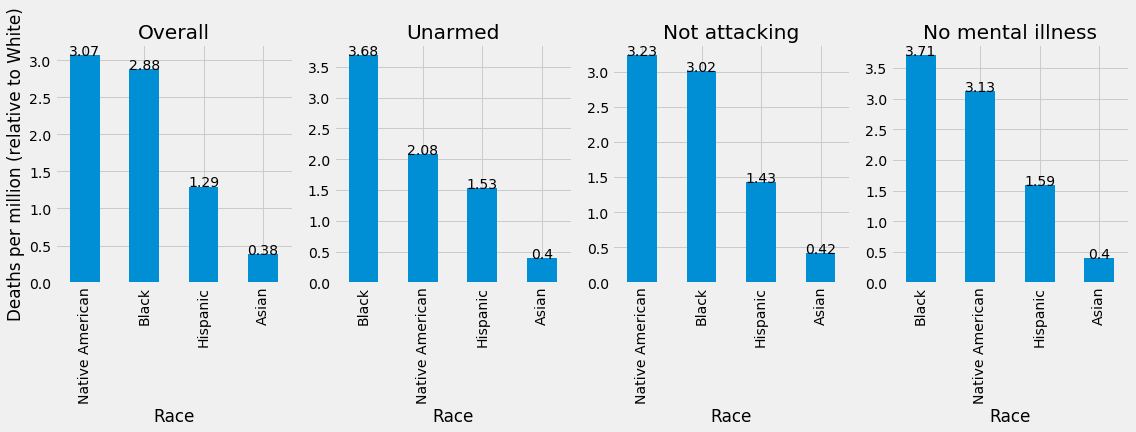

In [214]:
# Plot result
plt.figure(figsize=(16, 6))

# Overall (same as before)
plt.subplot(1, 4, 1)
graph1 = deaths_2white.plot(kind='bar')
graph1.set_xticklabels(graph1.get_xticklabels(), rotation=90)
i=0
for p in graph1.patches:
    height = p.get_height()
    graph1.text(p.get_x()+p.get_width()/2., height,
               deaths_2white.round(2)[i],ha="center")
    i += 1
plt.xlabel('Race')
plt.ylabel('Deaths per million (relative to White)')
plt.title('Overall')

# Unarmed
plt.subplot(1, 4, 2)
graph2 = unarmed_2white.plot(kind='bar')
graph2.set_xticklabels(graph2.get_xticklabels(), rotation=90)
i=0
for p in graph2.patches:
    height = p.get_height()
    graph2.text(p.get_x()+p.get_width()/2., height,
               unarmed_2white.round(2)[i],ha="center")
    i += 1
plt.xlabel('Race')
plt.ylabel('')
plt.title('Unarmed')

# Not attacking
plt.subplot(1, 4, 3)
graph3 = no_attack_2white.plot(kind='bar')
graph3.set_xticklabels(graph3.get_xticklabels(), rotation=90)
i=0
for p in graph3.patches:
    height = p.get_height()
    graph3.text(p.get_x()+p.get_width()/2., height,
               no_attack_2white.round(2)[i],ha="center")
    i += 1
plt.xlabel('Race')
plt.ylabel('')
plt.title('Not attacking')

# No mental illness
plt.subplot(1, 4, 4)
graph4 = no_mental_illness_2white.plot(kind='bar')
graph4.set_xticklabels(graph4.get_xticklabels(), rotation=90)
i=0
for p in graph4.patches:
    height = p.get_height()
    graph4.text(p.get_x()+p.get_width()/2., height,
               no_mental_illness_2white.round(2)[i],ha="center")
    i += 1
plt.xlabel('Race')
plt.ylabel('')
plt.title('No mental illness')

# Nicer spaing
plt.tight_layout()
plt.show()

Racial disparities became even more extreme among civilians who were unarmed, didn't attack the police, and showed no signs of mental illness. These results suggest that racial disparities in police killings can't be explained away by Blacks showing more threatening behaviors. We need more information to determine what exactly may be driving police officers' decisions.

## Where are racial disparities the most extreme?
Let's finally look at the top 5 states with the highest racial disparities. This is measured by each race's deaths per million relative to White in each state.

In [236]:
# Drop Pacific Islanders
data = data[(data['race']!= 'Pacific Islander')]

# Number of deaths by race (columns) and state (rows)
state_deaths = pd.crosstab(data['state'], data['race'])

# Add the above to the state-level race/ethnicity data
demo = demo.merge(state_deaths, on=['state'])

# Rename these new columns as {race}_deaths
new_names = ['asian_deaths', 'black_deaths', 'hispanic_deaths', 'native_deaths', 'white_deaths']
old_names = demo.columns[9:]
demo.rename(columns=dict(zip(old_names, new_names)), inplace=True)

In [237]:
# Calculate each race's death per million 
demo['white_per_million'] = demo['white_deaths']/demo['white_pop'] * 1e6
demo['black_per_million'] = demo['black_deaths']/demo['black_pop'] * 1e6
demo['hispanic_per_million'] = demo['hispanic_deaths']/demo['hispanic_pop'] * 1e6
demo['asian_per_million'] = demo['asian_deaths']/demo['asian_pop'] * 1e6
demo['native_per_million'] = demo['native_deaths']/demo['native_pop'] * 1e6

# Calculate each race's death per million relative to White
demo['black_2white'] = demo['black_per_million']/demo['white_per_million']
demo['hispanic_2white'] = demo['hispanic_per_million']/demo['white_per_million']
demo['asian_2white'] = demo['asian_per_million']/demo['white_per_million']
demo['native_2white'] = demo['native_per_million']/demo['white_per_million']

In [238]:
# Convert two-letter codes to full names of states
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Palau': 'PW',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

abbrev_us_state = dict(map(reversed, us_state_abbrev.items()))

demo['state'] = [abbrev_us_state[state] for state in demo['state']]

In [239]:
# Use state as index
demo.set_index('state', inplace=True)

In [240]:
# Top 5 Black to White
black_top10 = demo['black_2white'].sort_values(ascending=False).head(5)

# Top 5 Hispanic to White
hispanic_top10 = demo['hispanic_2white'].sort_values(ascending=False).head(5)

# Top 5 Asian to White
asian_top10 = demo['asian_2white'].sort_values(ascending=False).head(5)

# Top 5 Native American to White
native_top10 = demo['native_2white'].sort_values(ascending=False).head(5)

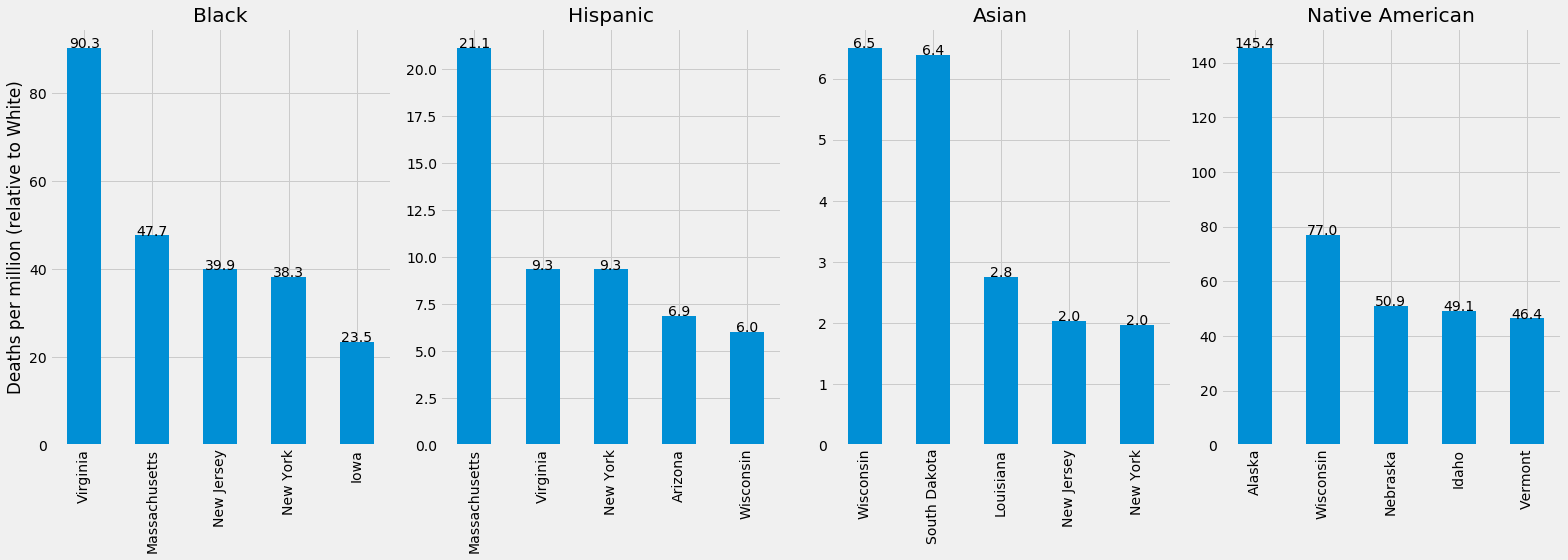

In [319]:
# Plot result
plt.figure(figsize=(22, 8))

# Black
plt.subplot(1, 4, 1)
graph1 = black_top10.plot(kind='bar')
graph1.set_xticklabels(graph1.get_xticklabels(), rotation=90)
i=0
for p in graph1.patches:
    height = p.get_height()
    graph1.text(p.get_x()+p.get_width()/2., height,
               black_top10.round(1)[i],ha="center")
    i += 1
plt.xlabel('')
plt.ylabel('Deaths per million (relative to White)')
plt.title('Black')

# Hispanic
plt.subplot(1, 4, 2)
graph2 = hispanic_top10.plot(kind='bar')
graph2.set_xticklabels(graph2.get_xticklabels(), rotation=90)
i=0
for p in graph2.patches:
    height = p.get_height()
    graph2.text(p.get_x()+p.get_width()/2., height,
               hispanic_top10.round(1)[i],ha="center")
    i += 1
plt.xlabel('')
plt.ylabel('')
plt.title('Hispanic')

# Asian
plt.subplot(1, 4, 3)
graph3 = asian_top10.plot(kind='bar')
graph3.set_xticklabels(graph3.get_xticklabels(), rotation=90)
i=0
for p in graph3.patches:
    height = p.get_height()
    graph3.text(p.get_x()+p.get_width()/2., height,
               asian_top10.round(1)[i],ha="center")
    i += 1
plt.xlabel('')
plt.ylabel('')
plt.title('Asian')

# Native American
plt.subplot(1, 4, 4)
graph4 = native_top10.plot(kind='bar')
graph4.set_xticklabels(graph4.get_xticklabels(), rotation=90)
i=0
for p in graph4.patches:
    height = p.get_height()
    graph4.text(p.get_x()+p.get_width()/2., height,
               native_top10.round(1)[i],ha="center")
    i += 1
plt.xlabel('')
plt.ylabel('')
plt.title('Native American')

# Nicer spaing
plt.tight_layout()
plt.show()

In states such as Virginia, Massachusetts, New Jersey, and New York, Black to White ratios in terms of deaths per million (90.3, 47.7, 39.9, and 38.3, respectively) far exceed that in the country (2.88:1). When pushing anti-bias training within the police force in the future, these states may need to be targeted first. 

Of course, we need further research to identify what is it about these states that might have led to high racial disparities. For instance, does the Black to White ratio in the population predict the disparity between Blacks and Whites? A quick look at data suggests a weak negative correlation between the two; without further work, it's hard to confirm this relationship or explain it.

In [305]:
# Calculate the Black to White ratio in the population
demo['black_2white_base'] = demo['black_pop']/demo['white_pop']

# Calculate the Black to White deaths in police killings
demo['black_2white'] = demo['black_per_million']/demo['white_per_million']

# Exclude NaNs and infinity 
demo = demo[~demo.isin([np.nan, np.inf, -np.inf]).any(1)]

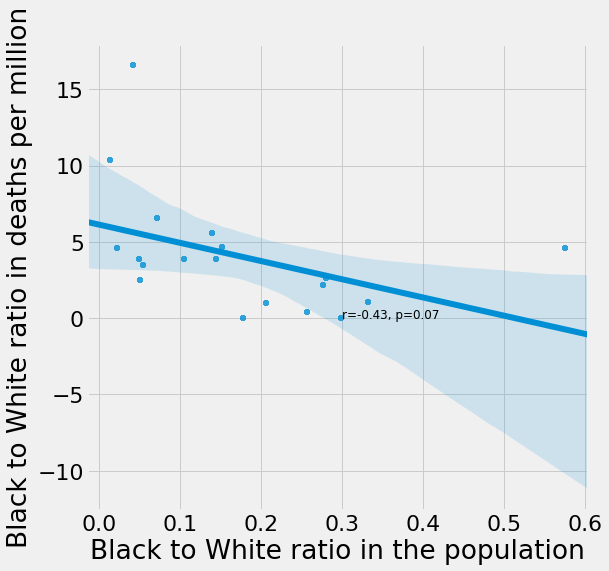

In [306]:
from scipy.stats import pearsonr
# Calculate correlation coefficient and p-value
corr = pearsonr(demo['black_2white_base'], demo['black_2white'])
corr = [np.round(c, 2) for c in corr]
text = 'r=%s, p=%s' % (corr[0], corr[1])
# Set figure size
plt.figure(figsize=(8, 8))
# Generate a regression plot w/ best fitting line
ax = sns.regplot(x="black_2white_base", y="black_2white", data=demo, marker="+")
# Change labels
plt.xlabel('Black to White ratio in the population')
plt.ylabel('Black to White ratio in deaths per million')
# Add coefficient and p-value
ax.text(0.3, 0.0, text, fontsize=12)

plt.show()

## Summary

This project is inspired by the many innocent Black lives taken by the police, often unjustified and unwarned. To examine whether Blacks are more likely to be killed by the police than Whites, I explored the Mapping Police Violence dataset, one of the most comprehensive and detailed datasets on police killings in the United States. The main findings are summarized below:

1. **Blacks are more likely to be killed by the police than Whites.** 
   - Compared to Whites, 2.88 times as many Blacks per million were killed by the police.
   - Both Black men and women were more likely to be killed than White men and women; the discrepancy is smaller in women.
   - Across the entire age spectrum, Blacks are more likely to be killed than Whites; age 18 to 40 is an especially vulnerable time for Blacks.
2. **The above disparity can't be explained by Blacks being more threatening.** 
   - In general, Blacks didn't show more threatening behavior than Whites; they were the least likely to carry arms or show signs of mental illness.
   - Rather than decreasing, disparities between Blacks and Whites became more extreme in unarmed civilians and those who didn't attack the police or show signs of mental illness.
3. **Disparities between Blacks and Whites are most extreme in Virgina, Massachusetts, New Jersey, and New York.**

## Future directions
All the analyses I did in this project are exploratory. Ultimately, I want to establish **causal relationships** between race and the risk of getting killed by the police. There is a long journey between showing racial disparities to making such claims. As the very first step, we need to estimate the **true prevalence** of each race's police killings from the data. As discuss, some races (e.g., Native Americans, Pacific Islanders) only have a small number of documented cases; even for Whites and Blacks, the record is incomplete. Rather than assuming the observe data represent the whole truth, we can use Bayesian statistics to obtain more rigorous estimation (Here's an [example](https://towardsdatascience.com/estimating-probabilities-with-bayesian-modeling-in-python-7144be007815) of estimating true prevalences of lions, tigers, and bears from a few encounters). Eventually, I aim to apply **formal models of causal inference** (e.g., Pearl, 2000) to examine, for instance, whether being Black is the cause of higher risk of police killing.

## Addendum 
### True prevalences
Based on the observed death counts, what is the true prevalence of police killings among each race? We can imagine that police killings were generated by a weighted 7-sided dice (6 sides for 6 known races and one for "other" or "unknown"), with the weights being the probabilities that a victim might be of a certain race. We can use Bayesian inference to estimate these probabilities.

In [254]:
# Import PyMC3
import pymc3 as pm
import numpy as np

In [275]:
# Set each race's base rate as priors
alphas = demo.iloc[:, 0:7].sum(axis=0).to_numpy()/demo['state_pop'].sum()

# Observed death counts 
counts = data['race'].value_counts().to_list()
counts.append(counts.pop(counts.index(550))) # Move unknown/other race to the end
d = counts.sum() # Total deaths

In [278]:
# Specify the model: Dirichlet-multinomial distribution
with pm.Model() as model:
    parameters = pm.Dirichlet('parameters', a=alphas, shape=7)
    observed_data = pm.Multinomial('observed_data', n=d, p=parameters, shape=7, observed=counts)

In [279]:
# Draw posterior samples
with model:
    trace = pm.sample(draws=10000, chains=2, tune=500, discard_tuned_samples = True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [parameters]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:17<00:00, 1173.78draws/s]


/Users/apple/anaconda3/lib/python3.7/site-packages/pymc3/plots/__init__.py:40: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


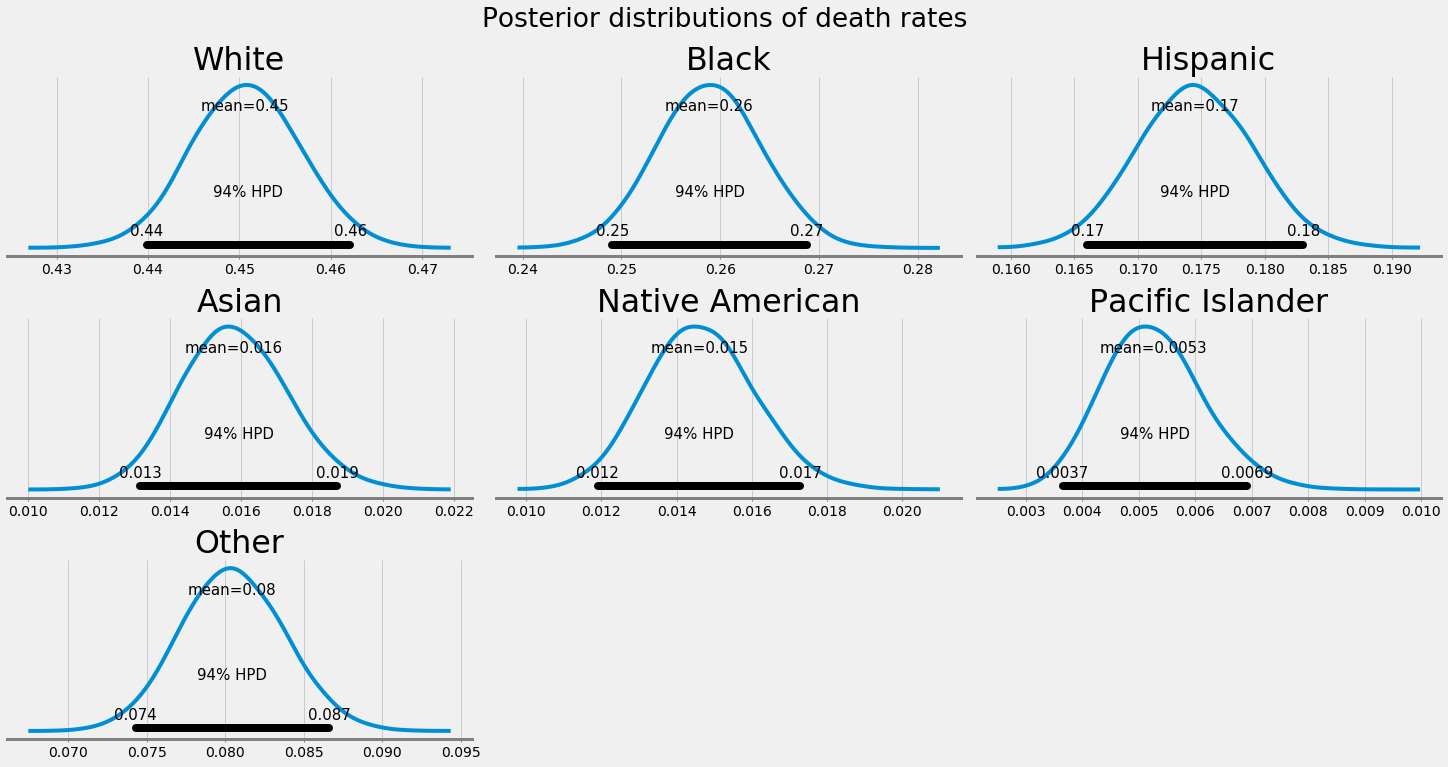

In [280]:
# Plot posterior distributions
ax = pm.plot_posterior(trace, varnames = ['parameters'], figsize = (20, 10))
plt.rcParams['font.size'] = 22
races = ['White', 'Black', 'Hispanic', 'Asian', 'Native American', 'Pacific Islander', 'Other']
for i, r in enumerate(races):
    ax[i].set_title(r);
    
plt.suptitle("Posterior distributions of death rates", y = 1.05);

Below is the the observed proportions of each race in police killings.

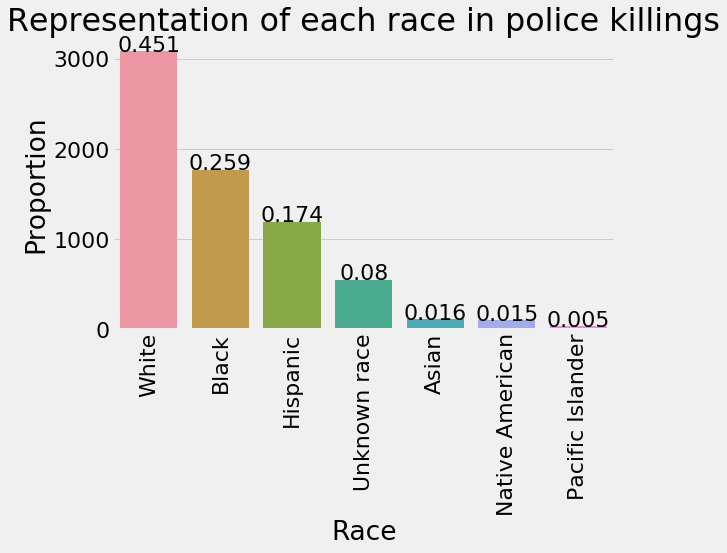

In [300]:
# Calculate the proportion of each race in police killings
proportions = data['race'].value_counts()/d

# Set figure size
plt.figure(figsize=(8,5))

# Plot each race's death count in descending order
graph = sns.countplot(x='race', 
                      data=data,
                      order = proportions.index)
graph.set_xticklabels(graph.get_xticklabels(), rotation=90)

# Add count to each bar
i=0
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height,
               proportions[i].round(3),ha="center")
    i += 1
    
# Title + labels
plt.title("Representation of each race in police killings")
plt.xlabel('Race')
plt.ylabel('Proportion')

plt.show()

Because of the large number of data, the underlying probabilities of the victim's race estimated by the Bayesian model match the observed proportions of each race's police killings almost exactly.